In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_env, plot_stats, seed_everything

In [2]:
import gym

# Create the environment

In [3]:
env = gym.make('MountainCar-v0')
seed_everything(env)
env.reset()

array([-0.4452088,  0.       ], dtype=float32)

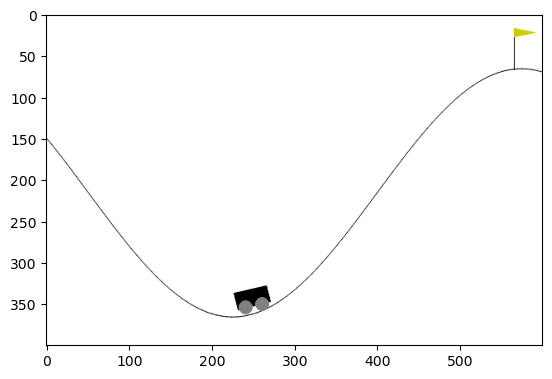

In [4]:
frame = env.render(mode='rgb_array')
plt.imshow(frame)

# Create the Tile Coding wrapper

In [62]:
class TileCodingEnv(gym.ObservationWrapper):

    def __init__(self, env, bins, low, high, n):
        # low = [-1.2, -0.07], high = [0.6, 0.7], bins = [20, 20]
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * 4)

    def observation(self, state):
        indices = []
        for t in self.tilings:
            tiling_indicies = tuple(np.digitize(i, b) for i, b in zip(state, t))
            indices.append(tiling_indicies)
            # print(tiling_indicies, indices)
        return indices

    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1, 2 * len(bins), 2)
        tilings = []
        
        for i in range(1, n + 1):
            low_i = low - np.random.random() * 0.2 * low
            high_i = high + np.random.random() * 0.2 * high
            segment_size = (high_i - low_i) / bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_size / n)
            low_i += displacements
            high_i += displacements
            bucket_i = [np.linspace(l, h, b - 1) for l, h, b in zip(low_i, high_i, bins)]
            tilings.append(bucket_i)
        return tilings

In [74]:
class TileCodingEnv(gym.ObservationWrapper):

    def __init__(self, env, bins, low, high, n=4):
        super().__init__(env)
        self.tilings = self._create_tilings(bins, high, low, n)

    def observation(self, obs):
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i, b) for i,b in zip(obs, t))
            indices.append(tiling_indices)
        return indices

    def _create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1,2*len(bins),2)
        tilings = []
        for i in range(1, n + 1):
            low_i = low - np.random.random() * .2 * low
            high_i = high + np.random.random() * .2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(j,k, l-1) for j,k,l in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        return tilings

In [75]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

In [76]:
tcenv.reset()

[(7, 8), (7, 9), (7, 8), (7, 8)]

# Compare the original environment to the one with aggregated states

In [77]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.observation_space.sample()}")

Modified observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.40185446 -0.03818658]


In [78]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.20174739 -0.06106558]


# Create the Q(s, a) table

In [79]:
action_values = np.zeros((4, 20, 20, 3))

# Create the e-greedy policy

In [80]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)

        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

# Test the SARSA algorithm on the modified environment

In [81]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)

            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)

            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [82]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:20<00:00, 141.88it/s]


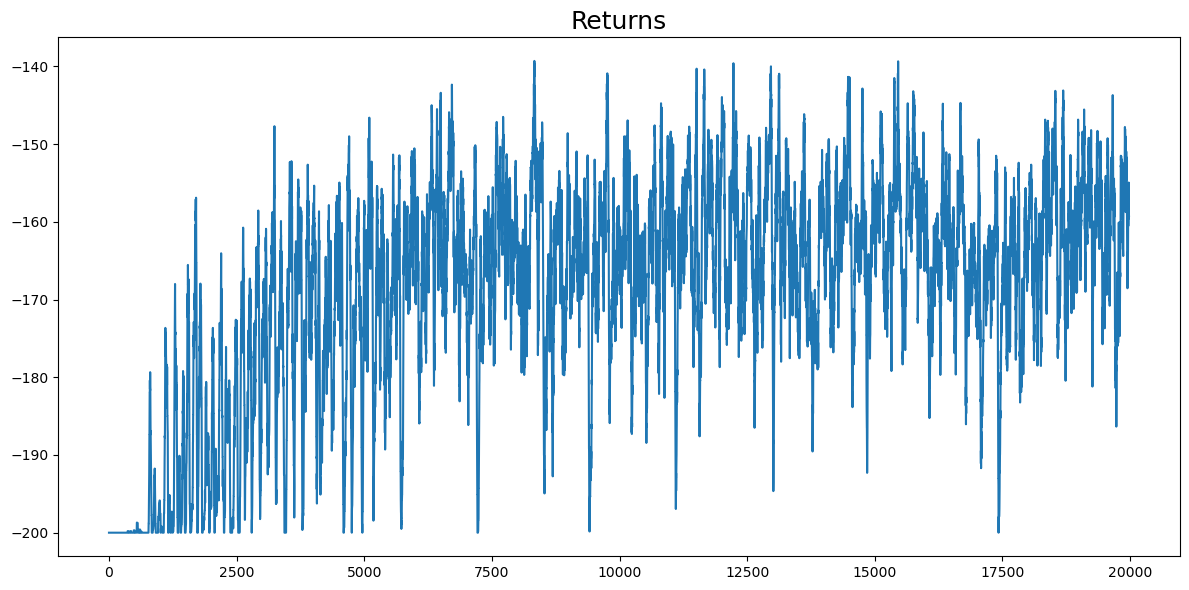

In [83]:
plot_stats(stats)

# Plot the learned policy

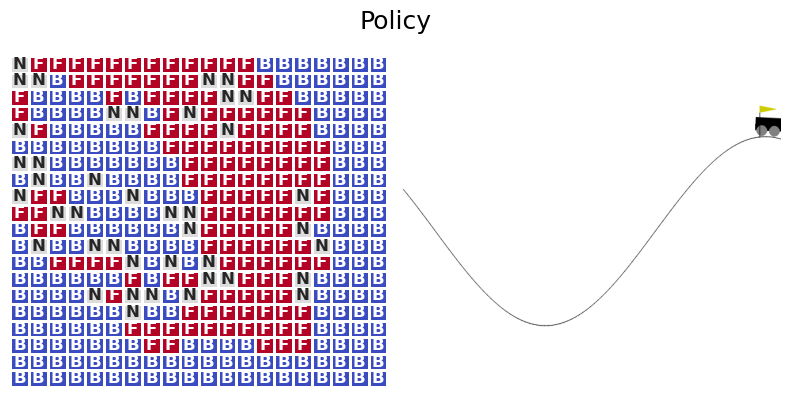

In [88]:
plot_policy(action_values.mean(axis=0), env.render(mode="rgb_array"),
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

# Plot the cost to go

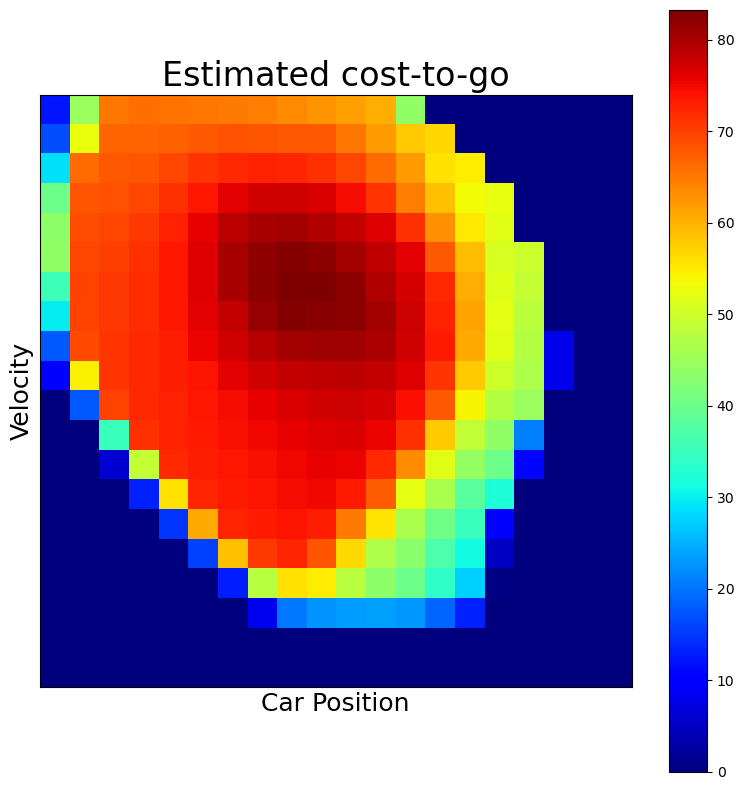

In [89]:
plot_tabular_cost_to_go(action_values.mean(axis=0), xlabel="Car Position", ylabel="Velocity")

# Test the resuling policy

In [85]:
from utils import test_agent

In [87]:
test_agent(tcenv, policy, episodes=1)